In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


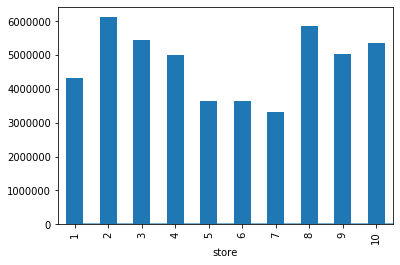

In [164]:
# data=pd.read_csv("/Users/Arsal/Downloads/demand-forecasting-kernels-only/train.csv")
data=pd.read_csv("C:\\Users\\Arsal\\Desktop\\Seasonal-ARIMA-Forecasting--master\\train.csv")
plt.plot(data[data.store==1].sales)
data.groupby("store")["sales"].sum().plot(kind='bar')

In [4]:
# ss=df_1_15
# ss['date']= pd.to_datetime(ss['date'], errors='coerce')
# ss['week_num']=ss['date'].dt.week
# ss['year']= ss['date'].dt.year
# ss['month']=ss['date'].dt.month
# """grouping based on weeks or months or years, 
# this will reduce the freuency of data"""
# df_m=ss.set_index('date').resample('M')["sales"].sum()
# # plt.plot(df_m)


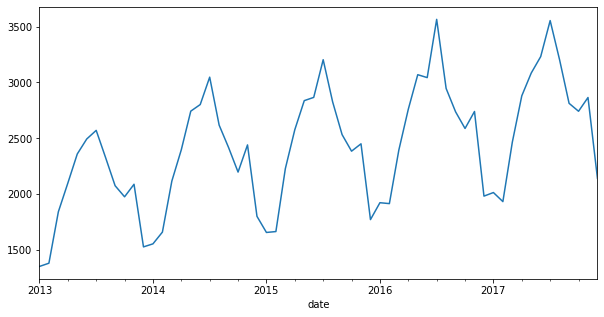

In [179]:
"""Plot the Time Series (ts)"""
plt.figure(figsize=(10,5))

df=data[(data.store==1) & (data.item==15)]
df['date']= pd.to_datetime(df_1_15['date'], errors='coerce')
df=df.reset_index()
# df_new.set_index('date').sales.plot()
df=df.set_index('date').resample('M')["sales"].sum()
df.plot()

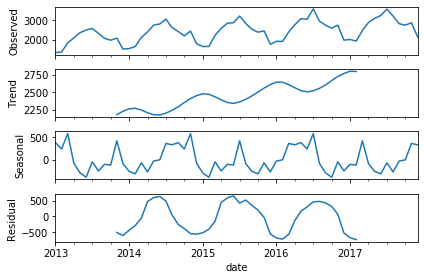

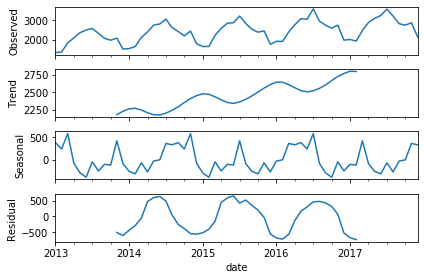

In [180]:
"""Time series decomposition"""
from statsmodels.tsa.seasonal import seasonal_decompose
# df_new_1= df_new.set_index('date')
# result= seasonal_decompose(df_new_1.iloc[:,3:4],freq=20)
result= seasonal_decompose(df,freq=20)
result.plot()

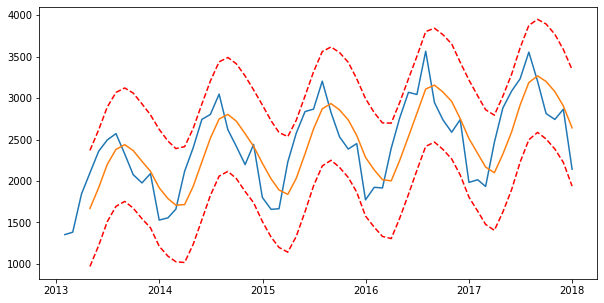

In [181]:
plt.figure(figsize=(10,5))
"""Moving Average"""
rolling_mean=df.rolling(window=4).mean()
# plt.plot(rolling_mean)
"""Plotting confidence intervals"""
mae=np.abs((df-rolling_mean)/df_new)*100
deviation=np.std(df-rolling_mean)
lower_bound= rolling_mean-(mae+1.96*deviation)
upper_bound= rolling_mean+(mae+1.96*deviation)
plt.plot(upper_bound,"r--",label="ss")
plt.plot(lower_bound,"r--")
plt.plot(df)
plt.plot(rolling_mean)

In [182]:
"""split the data into training and testing set"""
train=df.iloc[0:48]
test=df.iloc[48:]

In [226]:
"""Dickey Fuller Test to check if time series is stationary or not
The best way to model time series data is to remove the seasonal
and trend effects so the model can capture accurate information"""

from statsmodels.tsa.stattools import adfuller
def check_stationary(ts):
    result= adfuller(ts)
# result=adfuller(train)
    return print('ADF Statistic: %f' % result[0]),print('p-value: %f' % result[1])

check_stationary(train)

ADF Statistic: -0.948750
p-value: 0.771495


(None, None)

In [184]:
"""Log Tranformation"""
train=np.log(train)

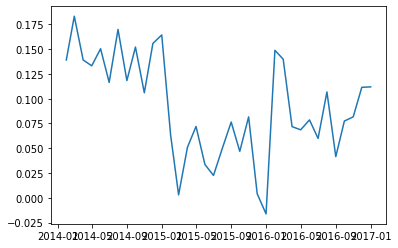

In [215]:
"""seasonal differencing"""
differenced= train.diff(12)
differenced=differenced.dropna(inplace=False)
plt.plot(differenced)

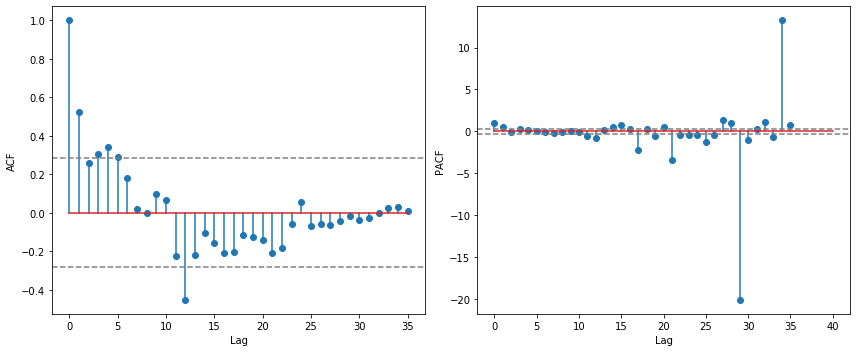

In [230]:
"""https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima"""

"""ACF and PCF plots"""
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
lag_acf= acf(differenced, nlags=40)
lag_pacf= pacf(differenced, nlags=40)

"""ACF"""
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.stem(lag_acf)
conf_interval= 1.96/np.sqrt(len(train))
plt.axhline(y=conf_interval, linestyle='--', color= 'gray')
plt.axhline(y=-conf_interval, linestyle='--', color= 'gray')
plt.xlabel("Lag")
plt.ylabel("ACF")


"""PACF"""
plt.subplot(122)
# plt.figure(figsize=(8,5))
plt.stem(lag_pacf)
conf_interval= 1.96/np.sqrt(len(train))
plt.axhline(y=conf_interval, linestyle='--', color= 'gray')
plt.axhline(y=-conf_interval, linestyle='--', color= 'gray')
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.tight_layout()

In [227]:
"""Running ADF again to check the p-value"""
check_stationary(differenced)


ADF Statistic: -3.049715
p-value: 0.030505


(None, None)

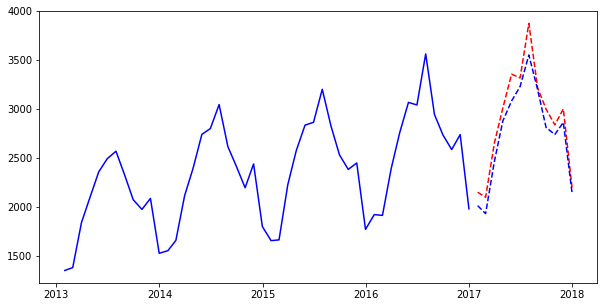

In [233]:
"""Nex we run the arima forecast"""
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train, order=(3,1,3), seasonal_order=(1,0,0,12), enforce_stationarity=False, enforce_invertibility=False)
model_fit=model.fit(disp=False)
forecast=model_fit.forecast(12)
forecast= np.exp(forecast)
"""plotting the error metrics"""
plt.figure(figsize=(10,5))
plt.plot(forecast, 'r--')
plt.plot(np.exp(train),'b')
plt.plot(test,'b--')


In [229]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              sales   No. Observations:                   48
Model:             SARIMAX(3, 1, 3)x(1, 0, 0, 12)   Log Likelihood                  57.577
Date:                            Wed, 16 Oct 2019   AIC                            -99.154
Time:                                    00:43:56   BIC                            -87.428
Sample:                                01-31-2013   HQIC                           -95.267
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3665      0.536     -2.551      0.011      -2.416      -0.317
ar.L2         -0.6777      0.898     -0.755      0.450      -2.438       1.082
ar.L3         -0.1475      0.481     -0.307      0.759      -1.089       0.794
ma.L1          1.1208      4.835      0.232      0.817      -8.356      10.598
ma.L2         -0.1439      2.450     -0.059      0.953      -4.946       4.658
ma.L3         -0.6382      3.683     -0.173      0.862      -7.857       6.581
ar.S.L12       0.9683      0.066     14.706      0.000       0.839       1.097
sigma2         0.0014      0.007      0.189      0.850      -0.013       0.015
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                10.48
Prob(Q):                               nan   Prob(JB):                         0.01
Heteroskedasticity (H):               0.16   Skew:                             0.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""